Download and extract files
--------------

In [64]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf
import json

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
plt.style.use('ggplot')

Download the original, variable-resolution, color house-number images with character level bounding boxes as show in the Street View House Numbers Dataset [SVHN](http://ufldl.stanford.edu/housenumbers/). 
The bounding box information are stored in `digitStruct.mat` instead of drawn directly on the images in the dataset. 


In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print('Failed to verify ' + filename + '. Please delete and try again')
  return filename

In [5]:
train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified train.tar.gz
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified test.tar.gz


In [49]:
extra_filename = maybe_download('extra.tar.gz', 0)

Attempting to download: extra.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Failed to verify extra.tar.gz. Please delete and try again


In [50]:
maybe_download('train_32x32.mat', 0)
maybe_download('test_32x32.mat', 0)
maybe_download('extra_32x32.mat', 0)

Failed to verify train_32x32.mat. Please delete and try again
Failed to verify test_32x32.mat. Please delete and try again
Failed to verify extra_32x32.mat. Please delete and try again


'extra_32x32.mat'

In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  if not os.path.exists(root+'/digitStruct.mat'):
    print("digitStruct.mat is missing")
  return root+'/digitStruct.mat'
  
train_struct = maybe_extract(train_filename)
test_struct = maybe_extract(test_filename)
# extra_struct = maybe_extract(extra_filename)

Extracting data for train. This may take a while. Please wait.
Extracting data for test. This may take a while. Please wait.


In [52]:
extra_struct = maybe_extract(extra_filename)

Extracting data for extra. This may take a while. Please wait.


The `digitStruct.mat` file contains a struct called **digitStruct** with the same length as the number of original images. 
Each element in **digitStruct** has the following fields: **name** which is a string containing the filename of the corresponding image. **bbox** which is a struct array that contains the **position, size and label** of each digit bounding box in the image. 
Eg: `digitStruct(300).bbox(2).height` gives height of the 2nd digit bounding box in the 300th image. 

In [8]:
pixel_depth = 255.0  # Number of levels per pixel.
screen_width = 800
screen_height = 600

In [18]:
import h5py
c=h5py.File('train/digitStruct.mat')

In [35]:
d=c[c['digitStruct']['bbox'][0][0]]['label'].value.squeeze()
# label of first image
np.array([c[x].value for x in d]).squeeze() 

array([ 1.,  9.])

In [43]:
d=c[c['digitStruct']['bbox'][0][0]]['top'].value.squeeze()
np.array([c[x].value for x in d]).squeeze() 

array([ 77.,  81.])

In [42]:
#filename of first image, then .replace('\x00', '')
c[c['digitStruct']['name'][0][0]].value.tostring() 

'1\x00.\x00p\x00n\x00g\x00'

In [47]:
import h5py # a Pythonic interface to the HDF5 binary data format

def get_attr(c, i, attr):
    d = c[c['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    if d.dtype == 'float64':
        return d.reshape(-1)
    return np.array([c[x].value for x in d]).squeeze()

def get_filename(c, i):
    d = c[c['digitStruct']['name'][i][0]].value.tostring()
    return d.replace('\x00', '')

def load_data(path):
    c = h5py.File(path)
    images = a = np.ndarray(shape=(c['digitStruct']['name'].shape[0], ), dtype='|S15')
    labels = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    labels.fill(10)
    tops = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    heights = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    widths = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    lefts = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    for i in xrange(c['digitStruct']['name'].shape[0]):
        images[i] = get_filename(c, i)
        y = get_attr(c, i, 'label')
        t = get_attr(c, i, 'top')
        h = get_attr(c, i, 'height')
        w = get_attr(c, i, 'width')
        l = get_attr(c, i, 'left')
        labels[i, :y.shape[0]] = y
        tops[i, :t.shape[0]] = t
        heights[i, :h.shape[0]] = h
        widths[i, :w.shape[0]] = w
        lefts[i, :l.shape[0]] = l
        if (i % 5000 == 0):
            print(i, "elapsed")
    return labels, images, tops, heights, widths, lefts

In [53]:
train__tuple = load_data('train/digitStruct.mat')
test__tuple = load_data('test/digitStruct.mat')
extra__tuple = load_data('extra/digitStruct.mat')

0 elapsed
5000 elapsed
10000 elapsed
15000 elapsed
20000 elapsed
25000 elapsed
30000 elapsed
0 elapsed
5000 elapsed
10000 elapsed
0 elapsed
5000 elapsed
10000 elapsed
15000 elapsed
20000 elapsed
25000 elapsed
30000 elapsed
35000 elapsed
40000 elapsed
45000 elapsed
50000 elapsed
55000 elapsed
60000 elapsed
65000 elapsed
70000 elapsed
75000 elapsed
80000 elapsed
85000 elapsed
90000 elapsed
95000 elapsed
100000 elapsed
105000 elapsed
110000 elapsed
115000 elapsed
120000 elapsed
125000 elapsed
130000 elapsed
135000 elapsed
140000 elapsed
145000 elapsed
150000 elapsed
155000 elapsed
160000 elapsed
165000 elapsed
170000 elapsed
175000 elapsed
180000 elapsed
185000 elapsed
190000 elapsed
195000 elapsed
200000 elapsed


In [100]:
def maybe_pickle(struct, force=False):
    if os.path.exists(struct + '.pickle') and not force:
        # You may override by setting force=True
        print('%s already present - Skipping pickling.' % struct)
    else:
        print('Pickling %s.' % struct + '.pickle')
        permutation = np.random.permutation(extra__tuple[1].shape[0])[:2000]
        attrs = ['labels', 'images', 'tops', 'heights', 'widths', 'lefts']
       
        d_train = {}
        d_test = {}
        d_extra = {}
        d_valid = {}
        for i, attr in enumerate(attrs):
            d_train[attr] = train__tuple[i]
            d_test[attr] = test__tuple[i]
            d_extra[attr] = extra__tuple[i]
            d_valid[attr] = extra__tuple[i][permutation]
            
        dataset = {'train': d_train, 'test': d_test, 
                   'extra': d_extra, 'valid': d_valid}
        try:
            with open(struct + '.pickle', 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', struct + '.pickle', ':', e)
    return struct + '.pickle'

In [56]:
extra__tuple[0][[1,2,3,4]] # labels for 2.png to 5.png

array([[  7.,   1.,  10.,  10.,  10.,  10.],
       [  1.,   7.,   4.,  10.,  10.,  10.],
       [  3.,  10.,  10.,  10.,  10.,  10.],
       [  2.,   8.,   8.,  10.,  10.,  10.]])

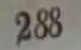

In [63]:
display(Image(filename="extra/5.png"))

In [101]:
maybe_pickle('svhn')

Pickling svhn..pickle


'svhn.pickle'

Data exploration
---------

- features and calculated statistics relevant to the problem
- a sampling of the data
- abnomalities, characteristics about the data

In [102]:
with open('svhn.pickle', 'rb') as f:
    dataset = pickle.load(f)

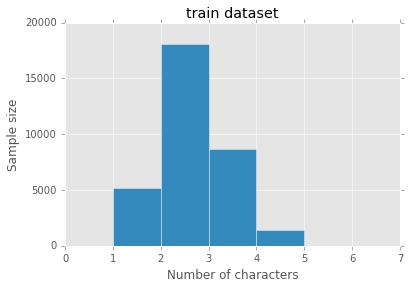

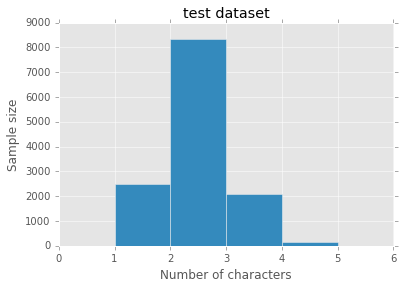

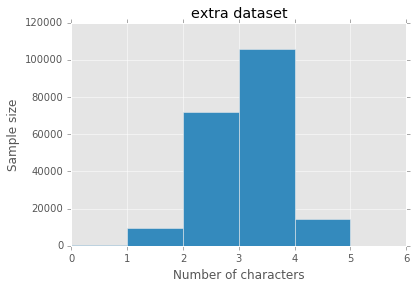

In [103]:
from collections import Counter

# number of digits in each image
def count_number_digits(source):
    c = Counter(np.sum(dataset[source]['tops'] > 0, axis=1))
    l = plt.bar(c.keys(), c.values(), 1)
    plt.xlabel('Number of characters')
    plt.ylabel('Sample size')
    plt.grid(True)
    plt.title(source + ' dataset')
    plt.show()

count_number_digits('train')
count_number_digits('test')
count_number_digits('extra')

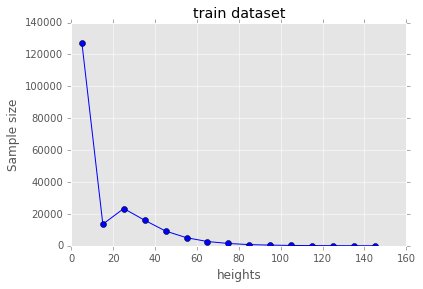

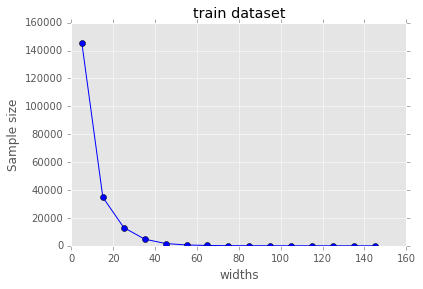

In [123]:
# size of images
def count_w_or_h(source, worh, color):
    hist =  np.histogram(dataset[source][worh], bins=range(0,160,10))
    plt.plot((hist[1][:-1] + hist[1][1:])/2.,hist[0][:], color)
    plt.title(source +' dataset')
    plt.ylabel('Sample size')
    plt.xlabel(worh)
    plt.show()

count_w_or_h('train', 'heights', 'bo-')
count_w_or_h('train', 'widths', 'bo-')

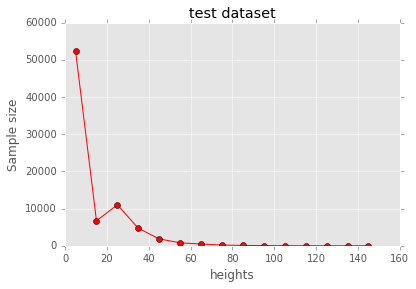

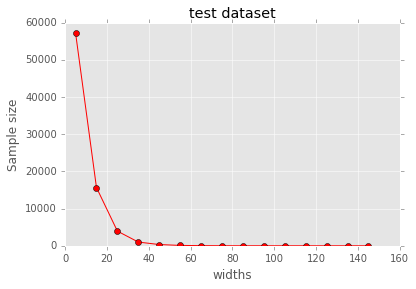

In [124]:
count_w_or_h('test', 'heights', 'ro-')
count_w_or_h('test', 'widths', 'ro-')

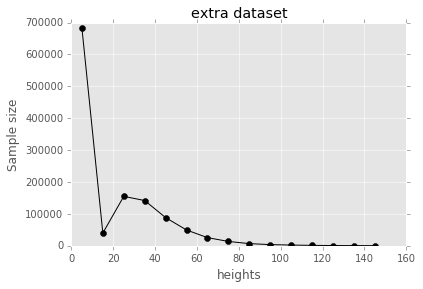

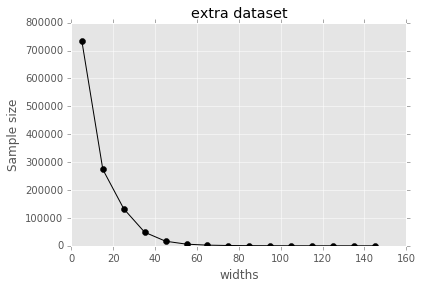

In [125]:
count_w_or_h('extra', 'heights', 'ko-')
count_w_or_h('extra', 'widths', 'ko-')

In [136]:
x= dataset['train']['labels'][0]
c= Counter(x)
print(c)
print(c[10])
print(c.keys()) 
print(c.values())

Counter({10.0: 4, 1.0: 1, 9.0: 1})
4
[1.0, 10.0, 9.0]
[1, 4, 1]


In [145]:
# Count how many 1's to 9's in each dataset
def count_number(source):
    allnum=[]
    for i in xrange(len(dataset[source]['labels'])):
        for x in dataset[source]['labels'][i]:
            if x != 10.0:
                allnum.append(x)
    c = Counter(allnum)
    #print(c)
    plt.bar(c.keys(), c.values(), 1)
    plt.title(source+' dataset')
    plt.xlabel('labels')
    plt.ylabel('number')
    plt.grid(True)
    plt.show()
    

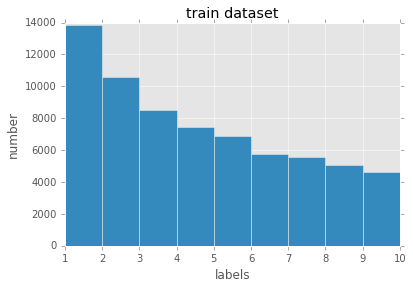

In [146]:
count_number('train')

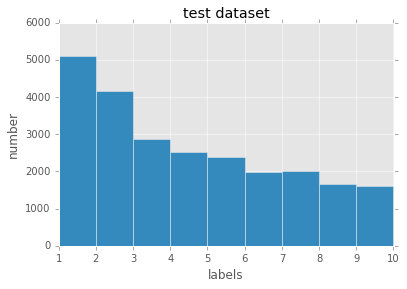

In [147]:
count_number('test')

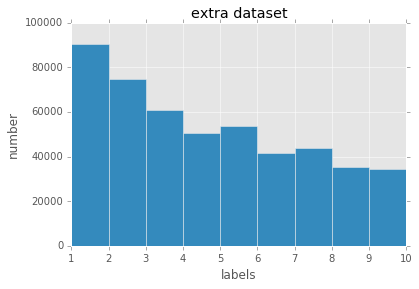

In [148]:
count_number('extra')